# Part 2: Embedding Search (with CLIP)
* **Created by:** Eric Martinez
* **For:** CSCI 4341
* **At:** University of Texas Rio-Grande Valley

Install the required dependencies.

In [1]:
%pip install -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-interpreter 0.1.0 requires openai<0.28.0,>=0.27.8, but you have openai 0.27.4 which is incompatible.
open-interpreter 0.1.0 requires tiktoken<0.5.0,>=0.4.0, but you have tiktoken 0.3.1 which is incompatible.
llava 1.0.2 requires gradio==3.35.2, but you have gradio 3.27.0 which is incompatible.
litellm 0.1.650 requires tiktoken<0.5.0,>=0.4.0, but you have tiktoken 0.3.1 which is incompatible.
orbit 0.1.0 requires openai==0.27.8, but you have openai 0.27.4 which is incompatible.
orbit 0.1.0 requires Requests==2.28.1, but you have requests 2.31.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install git+https://github.com/openai/CLIP.git

## Step 1: Create Helpful Functions for Working with CLIP

In [1]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def encode_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_tokens)[0]
    return text_embedding.tolist()

def encode_image(image):
    image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)[0]
    return image_features.tolist()

Let's try out the text embeddings

In [2]:
text = "a cute puppy"
text_embedding = encode_text(text)

print(len(text_embedding))

512


Now image embeddings

In [12]:
from PIL import Image
import requests

url = "https://media.istockphoto.com/id/157431311/photo/turkey-sandwich.jpg?s=612x612&w=0&k=20&c=uB6byErFAnWxFkkAqMiGNRJGE8r3nqsSDdqrfBE8HOA="
raw_image = Image.open(requests.get(url, stream=True).raw)

image_embedding = encode_image(raw_image)
print(len(image_embedding))

512


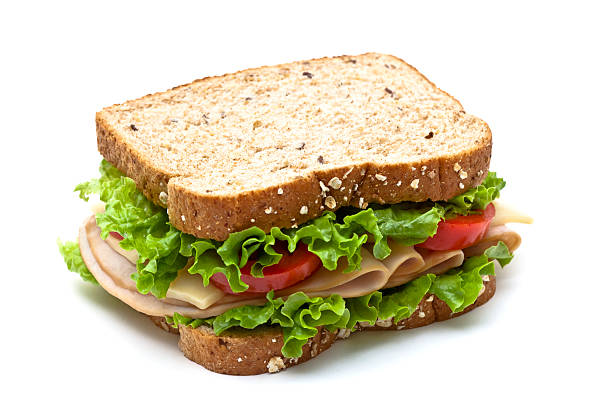

In [13]:
display(raw_image)

## Step 2: Create Custom Chroma Embedding Function for CLIP

In [3]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class CLIPEmbeddingFunction(EmbeddingFunction):
    def __call__(self, texts: Documents) -> Embeddings:
        embeddings = []
        
        for text in texts:
            text_embedding = encode_text(text)
            embeddings.append(text_embedding)
            
        return embeddings

## Step 3: Create new Chroma Collection

In [4]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.
import os

import chromadb
from chromadb.utils import embedding_functions


def get_chroma_collection(collection_name):
    ## Use this one to save to memory
    # chroma_client = chromadb.Client() 

    ## Use this one to save to disk
    chroma_client = chromadb.PersistentClient(path=".")

    clip_ef = CLIPEmbeddingFunction(device=device)

    collection = chroma_client.get_or_create_collection(name=collection_name, embedding_function=clip_ef)
    return collection

In [5]:
collection = get_chroma_collection("food_clip")

## Step 4: Add Data to Chroma Collection

In [6]:
import json

def load_data():
    with open("data.json") as f:
        data = json.load(f)
    return data

In [7]:
def add_data_to_collection(data, collection):
    documents = []
    metadatas = []
    ids = []

    for i, restaurant in enumerate(data):
        name = restaurant['name']
        address = restaurant['address']
        # TODO: add the other fields

        # TODO: what are we embedding for each restaurant - obviously add to this
        embeddable_string = f"{name}"
        documents.append(embeddable_string)

        # lets just store everything we have as metadata
        metadatas.append(restaurant)

        # lets use the index as the id
        ids.append(str(i))

    collection.add(
        documents=documents,
        metadatas=metadatas,
        ids=ids
    )

In [8]:
data = load_data()
add_data_to_collection(data, collection)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2


## Step 4: Query the Collection

Make some helper functions to query

In [9]:
def get_results_by_text(query, n_results=2):
    metadatas = []
    n_results = 2
    results = collection.query(query_texts=[query], n_results=2)
    
    for i in range(n_results):
        metadatas.append(results["metadatas"][0][i])
        
    return metadatas

def get_results_by_image(image, n_results=2):
    metadatas = []
    n_results = 2
    
    image_embedding = encode_image(image)
    results = collection.query(query_embeddings=[image_embedding], n_results=2)
    
    for i in range(n_results):
        metadatas.append(results["metadatas"][0][i])
        
    return metadatas

Test out querying by text

In [10]:
results = get_results_by_text("fajita", n_results=2)

for result in results:
    print(result)

{'address': '1414 W University Dr.', 'name': 'Taco Palenque'}
{'address': '1604 W University Dr', 'name': "Jason's Deli"}


Test out querying by image

In [14]:
# sandwhich image
url = "https://media.istockphoto.com/id/157431311/photo/turkey-sandwich.jpg?s=612x612&w=0&k=20&c=uB6byErFAnWxFkkAqMiGNRJGE8r3nqsSDdqrfBE8HOA="
raw_image = Image.open(requests.get(url, stream=True).raw)

results = get_results_by_image(raw_image, n_results=2)

for result in results:
    print(result)

{'address': '1604 W University Dr', 'name': "Jason's Deli"}
{'address': '1414 W University Dr.', 'name': 'Taco Palenque'}


## Step 5: Build the Gradio UI

In [15]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.
import gradio as gr
import openai
import pandas as pd
import gradio as gr

def search_by_text(query, n_results):
    results = get_results_by_text(query, n_results=n_results)

    try:
        df = pd.DataFrame(results, columns=['name', 'address'])
        return df
    except Exception as e:
        raise gr.Error(e.message)
        
        
def search_by_image(image, n_results):
    results = get_results_by_image(image, n_results=n_results)
    
    try:
        df = pd.DataFrame(results, columns=['name', 'address'])
        return df
    except Exception as e:
        raise gr.Error(e.message)

with gr.Blocks() as demo:
    with gr.Tab("Search by Text"):
        with gr.Row():
            with gr.Column():
                query = gr.Textbox(label="What are you looking for?", lines=5)
                text_n_results = gr.Slider(label="Results to Display", minimum=0, maximum=10, value=2, step=1)
                text_btn = gr.Button(value ="Submit")
                text_table = gr.Dataframe(label="Results", headers=['name', 'address'])
            text_btn.click(search_by_text, inputs = [query, text_n_results], outputs = [text_table])
            
    with gr.Tab("Search by Image"):
        with gr.Row():
            with gr.Column():
                image = gr.Image(label="Upload a picture", type='pil')
                image_n_results = gr.Slider(label="Results to Display", minimum=0, maximum=10, value=2, step=1)
                image_btn = gr.Button(value ="Submit")
                image_table = gr.Dataframe(label="Results", headers=['name', 'address'])
            image_btn.click(search_by_image, inputs = [image, image_n_results], outputs = [image_table])
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://1a4189c7c2bbe330b6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Your Job

#### 1. Modify code to use the same embedding approach from Part 1

- You probably included more than just the name, add all that stuff in


#### 2. Modify the UI on both tabs

- Add description of the restaurant to the table
- Add rating of the restaurant to the table
- Add anything else you included

#### Submit

In [ ]:
!git add assignment-part1.ipynb; git add assignment-part2.ipynb

In [ ]:
!git add data.json

In [ ]:
!git commit -m "finished part 2"

In [ ]:
!git push

That's it! 🎉 